#**Detecting Fake Reviews**

We will revisit this problem, seeing how sequence models can perform (perhaps they fare better than the simple unigram or bigram dense networks. Recall that this dataset is the product of research by a few folks in Computer Science: https://aclanthology.org/N13-1053.pdf. There is even a consumer-facing tool based on the model, here: http://reviewskeptic.com/. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from google.colab import files
import pandas as pd
import io
import numpy as np

# Just load the data from the Week 3 folder again.
trip_advisor = pd.read_csv('https://raw.githubusercontent.com/gburtch/BA865-2022/main/Week%203/datasets/deceptive-opinion.csv')
trip_advisor = trip_advisor.sample(frac=1) # Shuffle the data since I'll eventually just use a simple validation split.

trip_advisor.describe(include='all')

# Let's shuffle things... 
shuffled_indices= np.arange(trip_advisor.shape[0])
np.random.shuffle(shuffled_indices)

trip_advisor_text = trip_advisor['text'].to_numpy()
label = np.where(trip_advisor['deceptive']=='deceptive',1,0)

print(trip_advisor_text)
trip_advisor_text = trip_advisor_text[shuffled_indices]
label = label[shuffled_indices]
print(trip_advisor_text)

['My wife and I redeemed some of my Hilton Reward Points to stay a few nights at the Palmer House. The hotel is absolutely beautiful. From the moment you walk into the lobby you can tell that this place is nice. As we were Diamond members we got upgraded to a suite which was great because we were provided access to their executive lounge (free food & drinks). The service was excellent and the location of the hotel is within walking distance of many sights on the south side of Chicago. I would definitely recommend this hotel to anyone interested in coming to Chicago. \n'
 "I had high hopes for the Ambassador East Hotel, I really did. It seemed like a nice enough place with reasonably close beach access. I arrived to the hotel on a Tuesday afternoon. I was immediately surprised by the state of disrepair that the building was in. I could actually see two members of hotel maintenance in the parking lot sitting in their truck, doing nothing. As I walked in, nobody greeted me, and nobody off

Let's make a TextVectorization() layer to preprocess our text.

In [2]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=2000, # adding more tokens to allow for increase due to bigrams.
    output_mode="int", # This is requesting integer encodings (which means we'll have a sequence of integers)
)

text_vectorization.adapt(trip_advisor_text)

Just to see what this layer is doing to our reviews... 

In [3]:
review_text = trip_advisor_text[0]
print(f'REVIEW TEXT: \n\n{review_text}')
review_len = len(review_text.split(' '))
print(f'REVIEW DETAILS: \n\nThe review contains roughly {review_len} words (based on white spaces).')
vectorized_review = text_vectorization(trip_advisor_text)
print(f'It\'s vectorized (and padded) form contains {vectorized_review.shape[1]} tokens.\n') #Including the start index.
print(f'VECTOR REPRESENTATION:\n')
vectorized_review[0] # This text vectorization layer will convert a raw text vector into a sequence of integers.

REVIEW TEXT: 

Stayed here on business a few nights and really liked it. Very attractive, classy and comfortable hotel that's got an element of sexy and sharp. Public spaces are very nice, with an open area bar in the front lobby and nice sitting areas. Rooms are lovely as well, with handsome fixtures and furniture, a terrific desk work space and comfortable bed. Bathroom amenities and fixtures are sleek and attractive as well. Best of all, the hotel has breathtaking views of the city and the water - both the river and the lake. If you're working in the area, it's the best choice for that part of town, and I prefer it to the nearby Hyatt and Monaco. 

REVIEW DETAILS: 

The review contains roughly 118 words (based on white spaces).
It's vectorized (and padded) form contains 784 tokens.

VECTOR REPRESENTATION:



<tf.Tensor: shape=(784,), dtype=int64, numpy=
array([  48,   75,   24,  108,    5,  211,  162,    3,   99,  665,   14,
         29, 1639,  945,    3,  105,   10,  521,   80,   49,    1,    9,
          1,    3,    1,  982,    1,   44,   29,   64,   19,   49,  391,
        124,  158,    8,    2,   81,  111,    3,   64,  893,  645,   47,
         44,  552,   35,   94,   19,    1, 1106,    3,  503,    5, 1159,
         62,  184,  620,    3,  105,   73,   91,  287,    3, 1106,   44,
       1498,    3, 1639,   35,   94,  136,    9,   38,    2,   10,  109,
       1079,  393,    9,    2,  117,    3,    2,  170,  273,    2,  412,
          3,    2,  482,   54,  492,  518,    8,    2,  124,   90,    2,
        136,  508,   12,   18,  370,    9,  443,    3,    6, 1258,   14,
          4,    2,  662,  338,    3,  430,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

Before we proceed, do we expect a Sequence model to be helpful here (versus a bag of words model)? Recall, we should check the ratio of observations in training to mean number of tokens per sample. We don't expect to get much value at all from a sequential text model in this case, because we would need a much bigger dataset (on the order of 2.5 million observations). 

In [ ]:
lengths = [len(x) for x in vectorized_review]

print(f'The average review in our data has {np.mean(lengths)} words, and we have {len(trip_advisor)} samples.')
print(f'The ratio of samples to average sample length is thus {len(trip_advisor)/np.mean(lengths)}. We are nowhere close to 1500.')

The average review in our data has 784.0 words, and we have 1600 samples.
The ratio of samples to average sample length is thus 2.0408163265306123. We are nowhere close to 1500.


#*Model Using Bidirectional LSTM (No Embeddings Yet)*

We will one-hot encode these integer sequences into sparse, binary vector sequences, i.e., whereas a particular review would have been a one dimensional vector of integers (one integer per word), now we will have a two-dimensional array, with one vector per word.  

In [4]:
one_hot_review = tf.one_hot(vectorized_review, depth=2000) # Depth is the number of unique tokens in our sample (our vectorizer made it so we have no more than 2000)
print(one_hot_review.shape)

(1600, 784, 2000)


We will pass our integer sequences into a one-hot encoding layer, and from there into our Bidirectional LSTM.

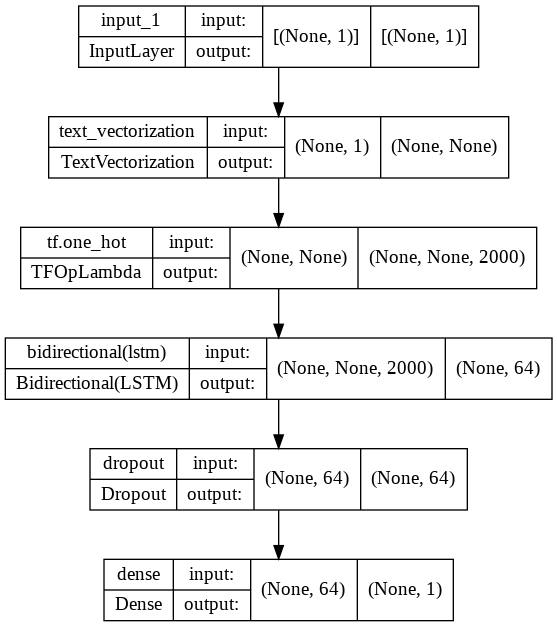

In [5]:
def build_model():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
    processing = text_vectorization(inputs)
    one_hot = tf.one_hot(processing, depth=2000) # we one-hot encode those, so it becomes a length x2000 vector.
    x = layers.Bidirectional(layers.LSTM(32))(one_hot)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model = build_model()

keras.utils.plot_model(model, show_shapes=True)

Now we can train our model... 

In [6]:
data_train = trip_advisor_text[:1200]
labels_train = label[:1200]
data_test = trip_advisor_text[1200:]
labels_test = label[1200:]

Now we will fit our model with cross-validation again, as before... 

In [7]:
k = 2
num_validation_samples = len(data_train) // k
num_epochs = 25
batch_sizes = 25
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/25
24/24 [==============================] - 11s 108ms/step - loss: 0.6908 - accuracy: 0.5333 - val_loss: 0.6878 - val_accuracy: 0.5133
Epoch 2/25
24/24 [==============================] - 2s 66ms/step - loss: 0.6892 - accuracy: 0.5950 - val_loss: 0.6663 - val_accuracy: 0.7833
Epoch 3/25
24/24 [==============================] - 2s 63ms/step - loss: 0.6427 - accuracy: 0.7350 - val_loss: 0.6221 - val_accuracy: 0.7217
Epoch 4/25
24/24 [==============================] - 2s 66ms/step - loss: 0.5746 - accuracy: 0.7967 - val_loss: 0.6234 - val_accuracy: 0.6717
Epoch 5/25
24/24 [==============================] - 2s 65ms/step - loss: 0.5377 - accuracy: 0.8033 - val_loss: 0.8026 - val_accuracy: 0.6450
Epoch 6/25
24/24 [==============================] - 2s 65ms/step - loss: 0.4737 - accuracy: 0.8333 - val_loss: 0.5191 - val_accuracy: 0.7367
Epoch 7/25
24/24 [==============================] - 2s 67ms/step - loss: 0.4079 - accuracy: 0.8517 - val_loss: 0.5750 - val_accuracy: 0.7467
Epoch 8/25


Finally, plot loss / accuracy over training... wow, this model peaks at about the 3rd epoch! It learns much faster than our old model did, though it gets to about the same level of performance. 



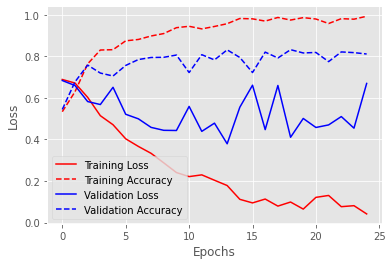

In [8]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

Let's see how we do on the holdout sample though. But wait! We dropped several features from the original dataset that we used last time. We might want to incorporate those other features into another branch of the network (another input layer).

In [9]:
model = build_model()
model.fit(data_train,labels_train,epochs=6,batch_size=25)

test_acc = model.evaluate(data_test,labels_test)[1]*100
print(f'The resulting model is about {test_acc:.2f}% accurate in the holdout sample.')

Epoch 1/6
48/48 [==============================] - 6s 44ms/step - loss: 0.6829 - accuracy: 0.5800
Epoch 2/6
48/48 [==============================] - 2s 45ms/step - loss: 0.5864 - accuracy: 0.7517
Epoch 3/6
48/48 [==============================] - 2s 43ms/step - loss: 0.4743 - accuracy: 0.8292
Epoch 4/6
48/48 [==============================] - 2s 43ms/step - loss: 0.4138 - accuracy: 0.8592
Epoch 5/6
48/48 [==============================] - 2s 43ms/step - loss: 0.3113 - accuracy: 0.9100
Epoch 6/6
13/13 [==============================] - 1s 23ms/step - loss: 0.4817 - accuracy: 0.7950
The resulting model is about 79.50% accurate in the holdout sample.


#*Textual Embeddings*

We can pre-process the text using an Embedding layer, before going to LSTM, to 'help the model along.' The Embedding layer will be of shape Vocabular-Size x Vector Length (dimensionality of the latent space). We can feed these sequences of vectors into our LSTM. 

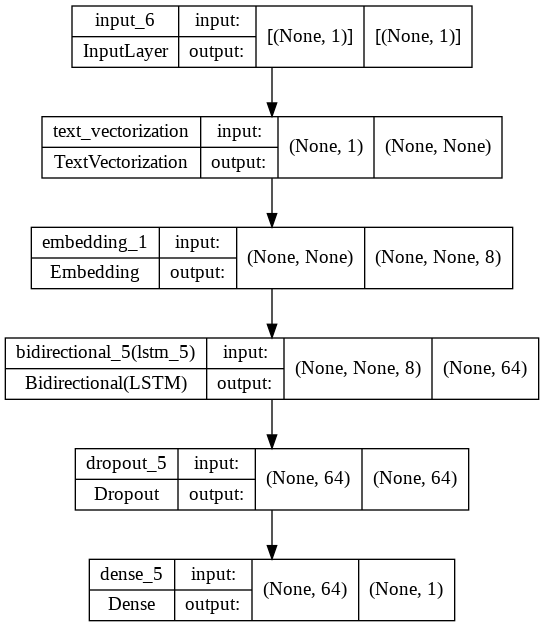

In [11]:
def build_model_embed():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
    processing = text_vectorization(inputs)
    
    # Truncates after 600 tokens, and pads up to 600 tokens for shorter reviews.
    # Mask zero means it will skip 0 tokens and will not pass them on.
    embedding = keras.layers.Embedding(input_dim=2000,output_dim=8,input_length=600, mask_zero=True)(processing)
    
    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(embedding)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model_embed = build_model_embed()

keras.utils.plot_model(model_embed, show_shapes=True)

Fit the model again... 

In [12]:
k = 2
num_validation_samples = len(data_train) // k
num_epochs = 25
batch_sizes = 25
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model_embed()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/25
24/24 [==============================] - 14s 184ms/step - loss: 0.6927 - accuracy: 0.5117 - val_loss: 0.6914 - val_accuracy: 0.4750
Epoch 2/25
24/24 [==============================] - 1s 44ms/step - loss: 0.6848 - accuracy: 0.5650 - val_loss: 0.6758 - val_accuracy: 0.5133
Epoch 3/25
24/24 [==============================] - 1s 45ms/step - loss: 0.6594 - accuracy: 0.6917 - val_loss: 0.6131 - val_accuracy: 0.8367
Epoch 4/25
24/24 [==============================] - 1s 45ms/step - loss: 0.4996 - accuracy: 0.7983 - val_loss: 0.4758 - val_accuracy: 0.7417
Epoch 5/25
24/24 [==============================] - 1s 46ms/step - loss: 0.3532 - accuracy: 0.8633 - val_loss: 0.4245 - val_accuracy: 0.8017
Epoch 6/25
24/24 [==============================] - 1s 44ms/step - loss: 0.2864 - accuracy: 0.8883 - val_loss: 0.4220 - val_accuracy: 0.8167
Epoch 7/25
24/24 [==============================] - 1s 45ms/step - loss: 0.2664 - accuracy: 0.8867 - val_loss: 0.3978 - val_accuracy: 0.8383
Epoch 8/25


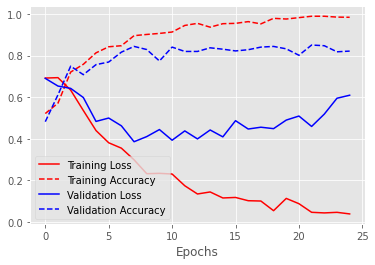

In [13]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

And we evaluate again on the test data... the custom embedding layer gets us up to 87% accuracy on the holdout data in this case.

In [ ]:
model_embed = build_model_embed()
model_embed.fit(data_train,labels_train,epochs=9,batch_size=25)

test_acc = model_embed.evaluate(data_test,labels_test)[1]*100
print(f'The resulting model is about {test_acc:.2f}% accurate in the holdout sample.')

Epoch 1/9
48/48 [==============================] - 11s 35ms/step - loss: 0.6900 - accuracy: 0.5550
Epoch 2/9
48/48 [==============================] - 2s 36ms/step - loss: 0.5854 - accuracy: 0.7283
Epoch 3/9
48/48 [==============================] - 2s 36ms/step - loss: 0.4303 - accuracy: 0.8258
Epoch 4/9
48/48 [==============================] - 2s 37ms/step - loss: 0.3427 - accuracy: 0.8567
Epoch 5/9
48/48 [==============================] - 2s 36ms/step - loss: 0.3123 - accuracy: 0.8717
Epoch 6/9
48/48 [==============================] - 2s 37ms/step - loss: 0.2369 - accuracy: 0.9158
Epoch 7/9
48/48 [==============================] - 2s 37ms/step - loss: 0.2146 - accuracy: 0.9208
Epoch 8/9
48/48 [==============================] - 2s 36ms/step - loss: 0.1488 - accuracy: 0.9475
Epoch 9/9
13/13 [==============================] - 3s 20ms/step - loss: 0.3573 - accuracy: 0.8675
The resulting model is about 86.75% accurate in the holdout sample.


#*GloVe Embeddings*

Let's see if we can use pre-trained GloVe embeddings to do better here. We will download the GloVe pre-trained embeddings (these are pre-trained embeddings from Wikipedia page data collected in 2014, as well as newswire data). Note that there are also GloVe embeddings that were trained from Twitter, which might be more appropriate for social media data: https://nlp.stanford.edu/projects/glove/

In [14]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-03-03 18:03:17--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-03 18:03:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-03 18:03:18--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

Note that there are about 1.2 million words in the English language. GloVe contains embeddings for about one third of those words (but that is going to cover most words you will encounter in regular usage!).

In [15]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt" 
  
embeddings_index = {} 
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1) # Split off only the first element in the row, i.e., the word, keep the remaining values as the vector.
        coefs = np.fromstring(coefs, "f", sep=" ") # Convert the set of numeric values into a numpy array, splitting elements by ' '
        embeddings_index[word] = coefs # Populate our dictionary - for this word (key), the vector representation is this vector (value).
  
glove_vec_lengths = len(coefs)

print(f"Found {len(embeddings_index)} word vectors.")
print(f"GloVe vector representations are {glove_vec_lengths} elements long.")

Found 400000 word vectors.
GloVe vector representations are 100 elements long.


We will now construct the Embedding matrix. This is the mapping between word tokens (integer indices) in our data and their vector representations.

In [16]:
vocabulary = text_vectorization.get_vocabulary()
print(f"Recall that our vocabulary has {len(vocabulary)} tokens in it.")
print(f"Here is the 11th word in our vocabulary: {vocabulary[13]}.") # Recall that the first two indices are reserved for 'padding' and 'UNK'

Recall that our vocabulary has 2000 tokens in it.
Here is the 11th word in our vocabulary: room.


In [17]:
embedding_dim = glove_vec_lengths # The length of the vector representations; the latent embedding space will be in 100 dimensions. 

vocabulary = text_vectorization.get_vocabulary() # From the vocabulary our text vectorizer learned from our dataset, go over every word.
word_index = dict(zip(vocabulary, range(len(vocabulary)))) # Make a dictionary, key is word to value is index.

# Instantiate a matrix of values (these will be the 'weights' in our embedding layer)
embedding_matrix = np.zeros((len(vocabulary), embedding_dim)) # It will be the 2000 tokens by 100 (length of GloVe vectors)
for word, i in word_index.items():
    if i < len(vocabulary):
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Here is the GloVe vector embedding for 'room'
embedding_matrix[13]

array([-0.024843  ,  0.47766   ,  0.32437   , -0.054239  , -0.47622001,
        1.10430002,  0.014733  ,  0.92413002, -0.0036772 , -0.29596999,
        0.54781997, -0.081146  , -0.021779  ,  0.51880002,  0.14273   ,
       -0.019756  , -0.4429    ,  0.45526001, -0.34454   , -0.81260002,
       -0.35356   ,  0.019425  , -0.26789001, -1.06159997,  0.27105001,
       -0.70291001, -0.14556   , -0.46669   , -0.38155001, -0.11217   ,
        0.14527   ,  0.047139  ,  0.076051  ,  0.64837998, -0.051128  ,
        1.01119995, -0.40836999,  0.34013   ,  0.75625998, -0.70703   ,
        0.23114   , -1.01240003,  0.16597   , -0.33013001,  0.43122   ,
        0.12475   , -0.87905997,  0.45133001,  0.74589002, -0.52077001,
        0.062784  , -0.55373001, -0.17152999,  1.02119994, -0.020486  ,
       -3.03209996, -0.26379001, -0.41382   ,  1.19669998,  0.45789999,
       -0.37781   ,  0.85339999,  0.15135001,  0.28586   , -0.04119   ,
       -0.057052  ,  1.32219994, -0.17764001, -0.21249001, -0.06

Now we use those vector representations to instantiate our Embedding layer. Rather than 'learning' the Embedding layer's weights, we will fix the weights to be the GloVe embeddings, and make them non-trainable. 

In [18]:
embedding_layer = layers.Embedding(
    len(vocabulary), # 2000 words.
    glove_vec_lengths, # Vectors of 100 elements per word.
    embeddings_initializer=keras.initializers.Constant(embedding_matrix), # Initialize with fixed values from our matrix.
    trainable=False, # These are weights, but they will be frozen so they don't update during training.
    mask_zero=True, # If we have a 0 token, for padding, we don't pass it through the layer.
)

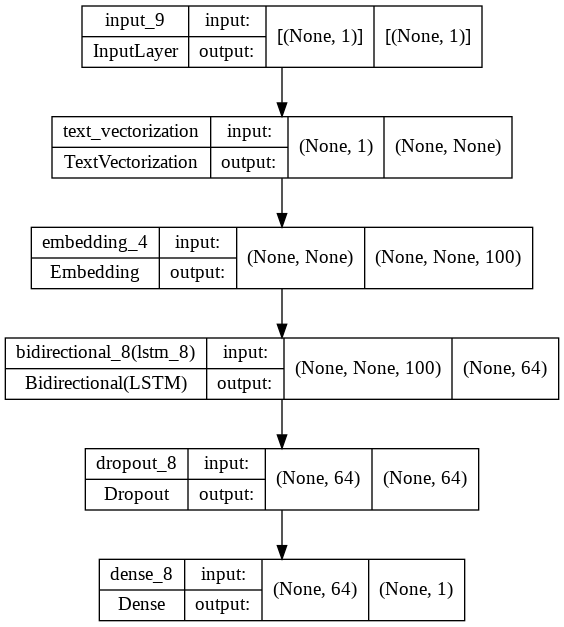

In [19]:
def build_model_GloVe():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
    processing = text_vectorization(inputs)
    
    embedding = embedding_layer(processing)
    
    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(embedding)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model_GloVe = build_model_GloVe()

keras.utils.plot_model(model_GloVe, show_shapes=True)

And, once again, let's cross validate... 

In [20]:
k = 2
num_validation_samples = len(data_train) // k
num_epochs = 25
batch_sizes = 25
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model_GloVe()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/25
24/24 [==============================] - 14s 174ms/step - loss: 0.6791 - accuracy: 0.5750 - val_loss: 0.6785 - val_accuracy: 0.5417
Epoch 2/25
24/24 [==============================] - 1s 48ms/step - loss: 0.6605 - accuracy: 0.5983 - val_loss: 0.6160 - val_accuracy: 0.7217
Epoch 3/25
24/24 [==============================] - 1s 43ms/step - loss: 0.6143 - accuracy: 0.6700 - val_loss: 0.5687 - val_accuracy: 0.7317
Epoch 4/25
24/24 [==============================] - 1s 44ms/step - loss: 0.5755 - accuracy: 0.7017 - val_loss: 0.5620 - val_accuracy: 0.7117
Epoch 5/25
24/24 [==============================] - 1s 45ms/step - loss: 0.5340 - accuracy: 0.7317 - val_loss: 0.5678 - val_accuracy: 0.7050
Epoch 6/25
24/24 [==============================] - 1s 46ms/step - loss: 0.5116 - accuracy: 0.7417 - val_loss: 0.5194 - val_accuracy: 0.7517
Epoch 7/25
24/24 [==============================] - 1s 45ms/step - loss: 0.4990 - accuracy: 0.7683 - val_loss: 0.4902 - val_accuracy: 0.7633
Epoch 8/25


Plotting average loss over training once again... 

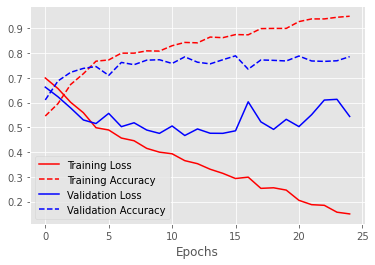

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

And, performance on the holdout data? We are actually doing substantially worse using those generic GloVe embeddings.

In [ ]:
model_glove = build_model_GloVe()
model_glove.fit(data_train,labels_train,epochs=9,batch_size=25)

test_acc = model_glove.evaluate(data_test,labels_test)[1]*100
print(f'The resulting model is about {test_acc:.2f}% accurate in the holdout sample.')

Epoch 1/9
48/48 [==============================] - 12s 36ms/step - loss: 0.6607 - accuracy: 0.5983
Epoch 2/9
48/48 [==============================] - 2s 35ms/step - loss: 0.5598 - accuracy: 0.7150
Epoch 3/9
48/48 [==============================] - 2s 36ms/step - loss: 0.5087 - accuracy: 0.7567
Epoch 4/9
48/48 [==============================] - 2s 36ms/step - loss: 0.4737 - accuracy: 0.7800
Epoch 5/9
48/48 [==============================] - 2s 36ms/step - loss: 0.4620 - accuracy: 0.7875
Epoch 6/9
48/48 [==============================] - 2s 35ms/step - loss: 0.4562 - accuracy: 0.7842
Epoch 7/9
48/48 [==============================] - 2s 36ms/step - loss: 0.4217 - accuracy: 0.8000
Epoch 8/9
48/48 [==============================] - 2s 39ms/step - loss: 0.4188 - accuracy: 0.8050
Epoch 9/9
13/13 [==============================] - 3s 21ms/step - loss: 0.5963 - accuracy: 0.7325
The resulting model is about 73.25% accurate in the holdout sample.


#*Word2Vec Embeddings*

Now we will try out the word2vec pre-trained embeddings (from Wikipedia). Let's download the English language, Wikipedia 100-dimensional embeddings. Note that this can take some time because the embedding file is large. 

In [ ]:
!wget http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.pkl.bz2
!bzip2 -d enwiki_20180420_100d.pkl.bz2

--2022-02-27 17:37:20--  http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.pkl.bz2
Resolving wikipedia2vec.s3.amazonaws.com (wikipedia2vec.s3.amazonaws.com)... 52.219.68.117
Connecting to wikipedia2vec.s3.amazonaws.com (wikipedia2vec.s3.amazonaws.com)|52.219.68.117|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3514838671 (3.3G) [application/x-bzip2]
Saving to: ‘enwiki_20180420_100d.pkl.bz2’

enwiki_20180420_100 100%[===================>]   3.27G  19.3MB/s    in 2m 58s  

2022-02-27 17:40:19 (18.8 MB/s) - ‘enwiki_20180420_100d.pkl.bz2’ saved [3514838671/3514838671]



Now let's create an embedding matrix, as before, etc. Note, we can see that most of the words for which we lack embeddings are actually typos or proper nouns. We could manually fix the typos, or not (perhaps the typos are indicative of deceipt!

In [ ]:
try:
  from wikipedia2vec import Wikipedia2Vec
except ImportError as error:
  !pip install wikipedia2vec
  from wikipedia2vec import Wikipedia2Vec

from wikipedia2vec import Wikipedia2Vec

# These embeddings are 100 dimensional also.
embedding_dim = 100

wiki2vec = Wikipedia2Vec.load('enwiki_20180420_100d.pkl')

vocabulary = text_vectorization.get_vocabulary() # From the vocabulary our text vectorizer learned from our dataset, go over every word.
word_index = dict(zip(vocabulary, range(len(vocabulary)))) # Make a dictionary, key is word to value is index.
embedding_matrix = np.zeros((len(vocabulary), embedding_dim))

for word, index in word_index.items():
    try:
        embedding_matrix[index] = wiki2vec.get_word_vector(f'{word}')
    except:
        print(f'Skipping {word}, no embedding for it.')
        continue

print(f'The embedding for \'room\' is {embedding_matrix[15]}.')

Skipping , no embedding for it.
Skipping [UNK], no embedding for it.
Skipping werent, no embedding for it.
Skipping inroom, no embedding for it.
Skipping hadnt, no embedding for it.
Skipping definately, no embedding for it.
Skipping shouldnt, no embedding for it.
Skipping accomodating, no embedding for it.
Skipping ohare, no embedding for it.
Skipping accomodations, no embedding for it.
Skipping definetly, no embedding for it.
Skipping shulas, no embedding for it.
The embedding for 'room' is [-0.04475478  0.52349627  0.15551241  0.13616104  0.00284019 -0.08661265
  0.05645907 -0.20347282  0.02514262 -0.50536108 -0.38650605 -0.0852759
  0.29945976 -0.11940839 -0.06857705 -0.17449841  0.2246068   0.13887054
  0.15167743  0.17579257  0.04217658 -0.10980772  0.09993367  0.01266596
 -0.20744962 -0.50846672  0.27036953 -0.18056074 -0.01523099  0.32400358
  0.19859086 -0.16741541 -0.17544943 -0.2759535  -0.40312016 -0.3360047
 -0.26442048 -0.25339603  0.28910047 -0.36898452  0.09097765 -0.053

And, again, let's make our embedding layer... 

In [ ]:
embedding_layer = layers.Embedding(
    len(vocabulary), # 2000 words.
    100, # Vectors of 100 elements per word.
    embeddings_initializer=keras.initializers.Constant(embedding_matrix), # Initialize with fixed values from our matrix.
    trainable=False, # These are weights, but they will be frozen so they don't update during training.
    mask_zero=True, # If we have a 0 token, for padding, we don't pass it through the layer.
)

And we instantiate the model again... 

In [ ]:
def build_model_word2vec():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
    processing = text_vectorization(inputs)
    
    embedding = embedding_layer(processing)
    
    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(embedding)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model_word2vec = build_model_word2vec()

And, let's fit the model one last time... once again, these don't help! The embeddings actually hurt. 

In [ ]:
k = 2
num_validation_samples = len(data_train) // k
num_epochs = 25
batch_sizes = 25
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model_word2vec()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/25
24/24 [==============================] - 14s 186ms/step - loss: 0.6817 - accuracy: 0.5767 - val_loss: 0.6501 - val_accuracy: 0.6333
Epoch 2/25
24/24 [==============================] - 1s 53ms/step - loss: 0.6512 - accuracy: 0.6050 - val_loss: 0.6017 - val_accuracy: 0.7000
Epoch 3/25
24/24 [==============================] - 1s 53ms/step - loss: 0.5921 - accuracy: 0.6767 - val_loss: 0.5598 - val_accuracy: 0.7383
Epoch 4/25
24/24 [==============================] - 1s 53ms/step - loss: 0.5585 - accuracy: 0.7300 - val_loss: 0.5230 - val_accuracy: 0.7600
Epoch 5/25
24/24 [==============================] - 1s 53ms/step - loss: 0.5351 - accuracy: 0.7367 - val_loss: 0.5553 - val_accuracy: 0.7200
Epoch 6/25
24/24 [==============================] - 1s 53ms/step - loss: 0.5115 - accuracy: 0.7467 - val_loss: 0.4838 - val_accuracy: 0.7567
Epoch 7/25
24/24 [==============================] - 1s 52ms/step - loss: 0.4977 - accuracy: 0.7767 - val_loss: 0.5251 - val_accuracy: 0.7217
Epoch 8/25


Plotting average model loss / accuracy across folds, over training.

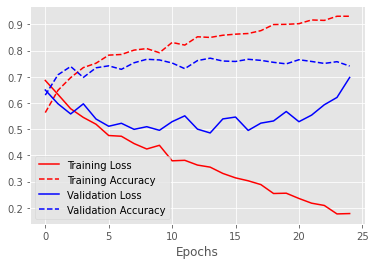

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

And, again, performance on the holdout data, which is what ultimately matters? Again, performance of about 77%. These pre-trained embeddings are doing more harm than good in this setting.

In [ ]:
model_word2vec = build_model_word2vec()
model_word2vec.fit(data_train,labels_train,epochs=9,batch_size=25)

test_acc = model_word2vec.evaluate(data_test,labels_test)[1]*100
print(f'The resulting model is about {test_acc:.2f}% accurate in the holdout sample.')

Epoch 1/9
48/48 [==============================] - 12s 36ms/step - loss: 0.6801 - accuracy: 0.5750
Epoch 2/9
48/48 [==============================] - 2s 36ms/step - loss: 0.5922 - accuracy: 0.6908
Epoch 3/9
48/48 [==============================] - 2s 35ms/step - loss: 0.5353 - accuracy: 0.7467
Epoch 4/9
48/48 [==============================] - 2s 37ms/step - loss: 0.4885 - accuracy: 0.7708
Epoch 5/9
48/48 [==============================] - 2s 35ms/step - loss: 0.4760 - accuracy: 0.7725
Epoch 6/9
48/48 [==============================] - 2s 36ms/step - loss: 0.4306 - accuracy: 0.8033
Epoch 7/9
48/48 [==============================] - 2s 36ms/step - loss: 0.4365 - accuracy: 0.7883
Epoch 8/9
48/48 [==============================] - 2s 36ms/step - loss: 0.4093 - accuracy: 0.8150
Epoch 9/9
13/13 [==============================] - 3s 20ms/step - loss: 0.4987 - accuracy: 0.7625
The resulting model is about 76.25% accurate in the holdout sample.
